In [ ]:
!nvidia-smi

Tue Jun 29 12:59:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/gdrive/My Drive/Dacon/thawpred/data_onlytrain.zip')
zip_file.extractall('./data')
print('data.zip extracted to local')

data.zip extracted to local


In [ ]:
import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export

class ConvLSTM2DCell(DropoutRNNCellMixin, Layer):

  def __init__(self,
               filters,
               kernel_size,
               strides=(1, 1),
               padding='valid',
               data_format=None,
               dilation_rate=(1, 1),
               activation='tanh',
               recurrent_activation='hard_sigmoid',
               use_bias=True,
               kernel_initializer='glorot_uniform',
               recurrent_initializer='orthogonal',
               bias_initializer='zeros',
               unit_forget_bias=True,
               kernel_regularizer=None,
               recurrent_regularizer=None,
               bias_regularizer=None,
               kernel_constraint=None,
               recurrent_constraint=None,
               bias_constraint=None,
               dropout=0.,
               recurrent_dropout=0.,
               **kwargs):
    super(ConvLSTM2DCell, self).__init__(**kwargs)
    self.filters = filters
    self.kernel_size = conv_utils.normalize_tuple(kernel_size, 2, 'kernel_size')
    self.strides = conv_utils.normalize_tuple(strides, 2, 'strides')
    self.padding = conv_utils.normalize_padding(padding)
    self.data_format = conv_utils.normalize_data_format(data_format)
    self.dilation_rate = conv_utils.normalize_tuple(dilation_rate, 2,
                                                    'dilation_rate')
    self.activation = activations.get(activation)
    self.recurrent_activation = activations.get(recurrent_activation)
    self.use_bias = use_bias

    self.kernel_initializer = initializers.get(kernel_initializer)
    self.recurrent_initializer = initializers.get(recurrent_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.unit_forget_bias = unit_forget_bias

    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.recurrent_regularizer = regularizers.get(recurrent_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)

    self.kernel_constraint = constraints.get(kernel_constraint)
    self.recurrent_constraint = constraints.get(recurrent_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

    self.dropout = min(1., max(0., dropout))
    self.recurrent_dropout = min(1., max(0., recurrent_dropout))
    self.state_size = (self.filters, self.filters)

  def build(self, input_shape):

    if self.data_format == 'channels_first':
      channel_axis = 1
    else:
      channel_axis = -1
    if input_shape[channel_axis] is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    input_dim = input_shape[channel_axis]
    kernel_shape = self.kernel_size + (input_dim, self.filters * 4)
    self.kernel_shape = kernel_shape
    recurrent_kernel_shape = self.kernel_size + (self.filters, self.filters * 4)

    self.kernel = self.add_weight(shape=kernel_shape,
                                  initializer=self.kernel_initializer,
                                  name='kernel',
                                  regularizer=self.kernel_regularizer,
                                  constraint=self.kernel_constraint)
    self.recurrent_kernel = self.add_weight(
        shape=recurrent_kernel_shape,
        initializer=self.recurrent_initializer,
        name='recurrent_kernel',
        regularizer=self.recurrent_regularizer,
        constraint=self.recurrent_constraint)

    if self.use_bias:
      if self.unit_forget_bias:

        def bias_initializer(_, *args, **kwargs):
          return backend.concatenate([
              self.bias_initializer((self.filters,), *args, **kwargs),
              initializers.get('ones')((self.filters,), *args, **kwargs),
              self.bias_initializer((self.filters * 2,), *args, **kwargs),
          ])
      else:
        bias_initializer = self.bias_initializer
      self.bias = self.add_weight(
          shape=(self.filters * 4,),
          name='bias',
          initializer=bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint)
    else:
      self.bias = None
    self.built = True

  def call(self, inputs, states, training=None):
    h_tm1 = states[0]  # previous memory state
    c_tm1 = states[1]  # previous carry state

    # dropout matrices for input units
    dp_mask = self.get_dropout_mask_for_cell(inputs, training, count=4)
    # dropout matrices for recurrent units
    rec_dp_mask = self.get_recurrent_dropout_mask_for_cell(
        h_tm1, training, count=4)

    if 0 < self.dropout < 1.:
      inputs_i = inputs * dp_mask[0]
      inputs_f = inputs * dp_mask[1]
      inputs_c = inputs * dp_mask[2]
      inputs_o = inputs * dp_mask[3]
    else:
      inputs_i = inputs
      inputs_f = inputs
      inputs_c = inputs
      inputs_o = inputs

    if 0 < self.recurrent_dropout < 1.:
      h_tm1_i = h_tm1 * rec_dp_mask[0]
      h_tm1_f = h_tm1 * rec_dp_mask[1]
      h_tm1_c = h_tm1 * rec_dp_mask[2]
      h_tm1_o = h_tm1 * rec_dp_mask[3]
    else:
      h_tm1_i = h_tm1
      h_tm1_f = h_tm1
      h_tm1_c = h_tm1
      h_tm1_o = h_tm1

    (kernel_i, kernel_f,
     kernel_c, kernel_o) = array_ops.split(self.kernel, 4, axis=3)
    (recurrent_kernel_i,
     recurrent_kernel_f,
     recurrent_kernel_c,
     recurrent_kernel_o) = array_ops.split(self.recurrent_kernel, 4, axis=3)

    if self.use_bias:
      bias_i, bias_f, bias_c, bias_o = array_ops.split(self.bias, 4)
    else:
      bias_i, bias_f, bias_c, bias_o = None, None, None, None

    x_i = self.input_conv(inputs_i, kernel_i, bias_i, padding=self.padding)
    x_f = self.input_conv(inputs_f, kernel_f, bias_f, padding=self.padding)
    x_c = self.input_conv(inputs_c, kernel_c, bias_c, padding=self.padding)
    x_o = self.input_conv(inputs_o, kernel_o, bias_o, padding=self.padding)
    h_i = self.recurrent_conv(h_tm1_i, recurrent_kernel_i)
    h_f = self.recurrent_conv(h_tm1_f, recurrent_kernel_f)
    h_c = self.recurrent_conv(h_tm1_c, recurrent_kernel_c)
    h_o = self.recurrent_conv(h_tm1_o, recurrent_kernel_o)

    i = self.recurrent_activation(x_i + h_i)
    f = self.recurrent_activation(x_f + h_f)
    c = f * c_tm1 + i * self.activation(x_c + h_c)
    o = self.recurrent_activation(x_o + h_o)
    h = o * self.activation(c)
    return h, [h, c]

  def input_conv(self, x, w, b=None, padding='valid'):
    conv_out = backend.conv2d(x, w, strides=self.strides,
                              padding=padding,
                              data_format=self.data_format,
                              dilation_rate=self.dilation_rate)
    if b is not None:
      conv_out = backend.bias_add(conv_out, b,
                                  data_format=self.data_format)
    return conv_out

  def recurrent_conv(self, x, w):
    conv_out = backend.conv2d(x, w, strides=(1, 1),
                              padding='same',
                              data_format=self.data_format)
    return conv_out

  def get_config(self):
    config = {'filters': self.filters,
              'kernel_size': self.kernel_size,
              'strides': self.strides,
              'padding': self.padding,
              'data_format': self.data_format,
              'dilation_rate': self.dilation_rate,
              'activation': activations.serialize(self.activation),
              'recurrent_activation': activations.serialize(
                  self.recurrent_activation),
              'use_bias': self.use_bias,
              'kernel_initializer': initializers.serialize(
                  self.kernel_initializer),
              'recurrent_initializer': initializers.serialize(
                  self.recurrent_initializer),
              'bias_initializer': initializers.serialize(self.bias_initializer),
              'unit_forget_bias': self.unit_forget_bias,
              'kernel_regularizer': regularizers.serialize(
                  self.kernel_regularizer),
              'recurrent_regularizer': regularizers.serialize(
                  self.recurrent_regularizer),
              'bias_regularizer': regularizers.serialize(self.bias_regularizer),
              'kernel_constraint': constraints.serialize(
                  self.kernel_constraint),
              'recurrent_constraint': constraints.serialize(
                  self.recurrent_constraint),
              'bias_constraint': constraints.serialize(self.bias_constraint),
              'dropout': self.dropout,
              'recurrent_dropout': self.recurrent_dropout}
    base_config = super(ConvLSTM2DCell, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import os

class Encoder(keras.Model):
    def __init__(self, hidden=10, num_layers=2, dropout=0.2):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.enc_layers = [layers.ConvLSTM2D(hidden, (3,3), padding="same", dropout=dropout,
                                             return_sequences=True, name="enc_" + str(i))
                           for i in range(num_layers - 1)] + \
                          [layers.ConvLSTM2D(hidden, (3,3), padding="same", dropout=dropout,
                                             return_sequences=True, return_state=True, name="end_last")]
    def call(self, x, training=None, mask=None):
        for i in range(self.num_layers-1):
            x = self.enc_layers[i](x)
        out, h, c = self.enc_layers[-1](x)
        return out, [h, c]

class Attention(keras.Model):  # pixel attention
    def __init__(self, units=12):
        super(Attention, self).__init__()
        self.queryimage2query = keras.models.Sequential([layers.GlobalMaxPooling2D(),
                                                         layers.Dense(units)])
        self.keyimage2key = layers.Dense(units)
        self.score = layers.Dense(1)

    def call(self, query, key):  # key == value
        '''
        query = dec_hidden ==> query.shape = (batch,h,w,hidden)
        key = enc_output_seq ==> key.shape = (batch,24,h,w,hidden)
        '''
        q = self.queryimage2query(query)    # (batch,units)
        q = tf.expand_dims(q, 1)    # (batch,1,units)  : for summation with k

        k = keras.backend.max(key, axis=[2,3])    # (batch,24,hidden)
        k = self.keyimage2key(k)    # (batch,24,units)

        score = self.score(tf.nn.tanh(q+k))  # (batch,24,1)
        prob = tf.nn.softmax(score, axis=1)
        prob = prob[..., tf.newaxis, tf.newaxis]    # (batch,24,1,1,1)

        context = tf.math.multiply(prob,key)
        context = tf.math.reduce_sum(context, axis=1)  # (batch,h,w,hidden)
        return context

class Decoder_1step(keras.Model):
    def __init__(self, hidden=10, num_layers=2, dropout=0.2):
        super(Decoder_1step, self).__init__()
        self.num_layers = num_layers
        self.hidden = hidden
        self.dec_cells = [ConvLSTM2DCell(hidden, (3,3), padding="same", dropout=dropout,
                                                name="dec_" + str(i)) for i in range(num_layers)]
        self.attention = Attention()
        self.decoder_output_layer = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")

    def call(self, x, state, enc_out_seq, states):  # x.shape == (batch,h,w,hidden)
        h, c = state
        context = self.attention(query=h, key=enc_out_seq)
        x = tf.concat([context, x], axis=-1)
        for i in range(self.num_layers):
            x, state = self.dec_cells[i](x, states=states[i])
            states[i] = state
        out = self.decoder_output_layer(x)
        return out, states[0], states

    def call_all_steps(self, x, state, enc_out_seq, timesteps, states):
        h, c = state
        res = []
        for t in range(timesteps):
            context = self.attention(query=h, key=enc_out_seq)
            x = tf.concat([context, x], axis=-1)
            for i in range(self.num_layers):
                x, state = self.dec_cells[i](x, states=states[i])
                states[i] = state
            x = self.decoder_output_layer(x)
            h, _ = states[0]
            res.append(x)
        out = tf.stack(res, axis=1)
        return out

    def init_hidden(self, inputs):
        b, h, w, _ = keras.backend.int_shape(inputs)
        return [[tf.zeros([b,h,w,self.hidden]),tf.zeros([b,h,w,self.hidden])] for _ in range(self.num_layers)]

In [ ]:
DEFAULT_PATH = "./"
default_path = DEFAULT_PATH
INPUT_WINDOW_SIZE = 24
TARGET_WINDOW_SIZE = 12
BATCH_SIZE = 1
VERBOSE = 1
modelname = "convlstm_att_final"
save_path = '/content/gdrive/My Drive/Dacon/thawpred/' + modelname + '/'
HIDDEN = 24
LAYERS = 1

print("starting to get data")

train = pd.read_csv(default_path + 'data/weekly_train.csv')
test = pd.read_csv(default_path + 'data/public_weekly_test.csv')
train_data_path = default_path + 'data/weekly_train/' + train['week_file_nm'].values

input_window_size = INPUT_WINDOW_SIZE
target_window_size = TARGET_WINDOW_SIZE
gap = 2
step = 1
input_data_list, target_data_list = [], []

for i in range(0, len(train_data_path) - input_window_size - target_window_size - gap + 1, step):
    input_data = train_data_path[i:i + input_window_size]
    target_data = train_data_path[i + input_window_size + gap:i + input_window_size + gap + target_window_size]
    input_data_list.append(input_data)
    target_data_list.append(target_data)


def train_map_func(x_list, y_list):
    train_x, train_y = [], []
    for path in x_list:
        train_x.append(np.load(path)[:, :, 0:1])
    for path in y_list:
        train_y.append(np.load(path)[:, :, 0:1])
    train_x = np.array(train_x)
    train_y = np.array(train_y)

    train_x = train_x.astype(np.float32) / 250
    train_y = train_y.astype(np.float32) / 250
    return train_x, train_y


train_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[:-52], target_data_list[:-52]))
train_dataset = train_dataset.map(
    lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((input_data_list[-52:], target_data_list[-52:]))
val_dataset = val_dataset.map(
    lambda item1, item2: tf.numpy_function(train_map_func, [item1, item2], [tf.float32, tf.float32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print("data export done, preparing model...")

@tf.function
def loss_function(output, target):
    mae_loss = tf.math.reduce_mean(tf.keras.losses.MAE(output, target))
    return mae_loss

encoder = Encoder(hidden=HIDDEN, num_layers=LAYERS)
decoder_1step = Decoder_1step(hidden=HIDDEN, num_layers=LAYERS)
optimizer = tf.keras.optimizers.Adam(0.0005)

@tf.function
def train_step(inp, targ):
    loss = 0

    with tf.GradientTape() as tape:
        enc_out_seq, state = encoder(inp)
        dec_input = inp[:,-1,:,:,:]
        states = decoder_1step.init_hidden(dec_input)
        # teacher forcing
        _, timesteps, _, _, _ = tf.keras.backend.int_shape(targ)  # batch, time, w, h, 1
        for t in range(timesteps):
            prediction, state, states = decoder_1step(dec_input, state, enc_out_seq, states)
            loss += loss_function(targ[:, t], prediction)
            dec_input = targ[:,t,:,:,:]

    batch_loss = (loss / int(timesteps))
    variables = encoder.trainable_variables + decoder_1step.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

def call_model(inp):
    enc_out_seq, state = encoder(inp)
    x = inp[:,-1,:,:,:]
    states = decoder_1step.init_hidden(x)
    out = decoder_1step.call_all_steps(x, state, enc_out_seq, 12, states)
    return out
############
def mae_score(true, pred):
    score = np.mean(np.abs(true - pred))
    return score
def f1_score(true, pred):
    target = np.where((true > 0.05) & (true < 0.5))

    true = true[target]
    pred = pred[target]

    true = np.where(true < 0.15, 0, 1)
    pred = np.where(pred < 0.15, 0, 1)

    right = np.sum(true * pred == 1)
    precision = right / np.sum(true + 1e-8)
    recall = right / np.sum(pred + 1e-8)

    score = 2 * precision * recall / (precision + recall + 1e-8)

    return score
def mae_over_f1(true, pred):
    mae = mae_score(true, pred)
    f1 = f1_score(true, pred)
    score = mae / (f1 + 1e-8)

    return score
#############

def val_score(inp, targ):
    output = call_model(inp)
    score = mae_over_f1(targ.numpy(), output.numpy())
    return score

print('preparing checkpoint...')

checkpoint_path = save_path
os.makedirs(checkpoint_path, exist_ok=True)
ckpt = tf.train.Checkpoint(
    encoder=encoder,
    decoder_1step=decoder_1step,
    optimizer=optimizer
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(ckpt_manager.latest_checkpoint)

starting to get data
data export done, preparing model...
preparing checkpoint...
/content/gdrive/My Drive/Dacon/thawpred/convlstm_att_final/ckpt-16


0it [00:00, ?it/s]

starting to train...


2137it [11:26,  3.11it/s, Epoch=1, Loss=3.485560, Total Loss=7.851603]
52it [00:12,  4.27it/s, Epoch=1, Val Score=13.944143, Val Total_Score=30.746382]
2137it [11:46,  3.02it/s, Epoch=2, Loss=3.889763, Total Loss=3.195150]
52it [00:12,  4.24it/s, Epoch=2, Val Score=12.576494, Val Total_Score=21.004224]
2137it [11:03,  3.22it/s, Epoch=3, Loss=2.779285, Total Loss=2.840920]
52it [00:12,  4.26it/s, Epoch=3, Val Score=10.878974, Val Total_Score=18.435382]
2137it [11:04,  3.22it/s, Epoch=4, Loss=2.621963, Total Loss=2.641166]
52it [00:12,  4.32it/s, Epoch=4, Val Score=8.786028, Val Total_Score=18.318186]
2137it [11:04,  3.22it/s, Epoch=5, Loss=2.576591, Total Loss=2.531802]
52it [00:12,  4.22it/s, Epoch=5, Val Score=8.031734, Val Total_Score=16.069498]
2137it [11:04,  3.22it/s, Epoch=6, Loss=2.593110, Total Loss=2.462005]
52it [00:11,  4.38it/s, Epoch=6, Val Score=7.846882, Val Total_Score=14.057627]
2137it [11:03,  3.22it/s, Epoch=7, Loss=2.582833, Total Loss=2.423060]
52it [00:11,  4.39it

saving plot...


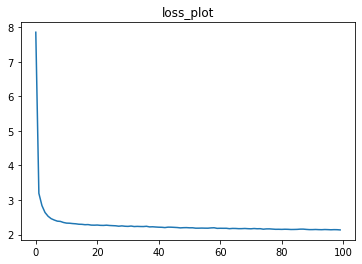

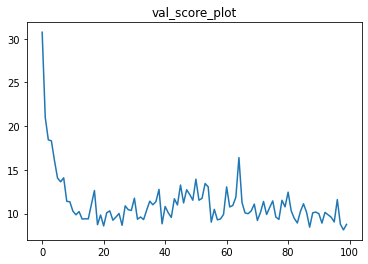

restoring ckpt
ckpt restored.


In [ ]:
print("starting to train...")
EPOCHS = 100

loss_plot, val_score_plot = [], []
for epoch in range(start_epoch, EPOCHS):
    total_loss, total_val_score = 0, 0

    tqdm_dataset = tqdm(enumerate(train_dataset))
    for (batch, (inp, targ)) in tqdm_dataset:
        batch_loss = train_step(inp, targ)
        total_loss += batch_loss

        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(250 * batch_loss.numpy().mean()),
            'Total Loss': '{:06f}'.format(250 * total_loss / (batch + 1))
        })
    loss_plot.append(250 * total_loss / (batch + 1))

    tqdm_dataset_val = tqdm(enumerate(val_dataset))
    for (batch, (inp, targ)) in tqdm_dataset_val:
        batch_val_score = val_score(inp, targ)
        total_val_score += batch_val_score.mean()

        tqdm_dataset_val.set_postfix({
            'Epoch': epoch + 1,
            'Val Score': '{:06f}'.format(250 * batch_val_score.mean()),
            'Val Total_Score': '{:06f}'.format(250 * total_val_score / (batch + 1))
        })
    val_score_plot.append(250 * total_val_score / (batch + 1))

    if np.min(val_score_plot) == val_score_plot[-1]:
        ckpt_manager.save()

print("saving plot...")
plt.plot(loss_plot)
plt.title('loss_plot')
plt.show()

plt.plot(val_score_plot)
plt.title('val_score_plot')
plt.show()

print("restoring ckpt")
ckpt.restore(ckpt_manager.latest_checkpoint)
print("ckpt restored.")

In [ ]:
'''print("getting testfile")
test = pd.read_csv('data/public_weekly_test.csv')
test_path = './data/weekly_train/'+test.tail(24)['week_file_nm']

def predict(img_path):
    test_imgs = []
    for path in img_path:
        test_imgs.append(np.load(path)[:, :, 0:1].astype(np.float32) / 250)
    test_imgs = np.array([test_imgs])
    enc_input = tf.convert_to_tensor(test_imgs)
    pred = call_model(enc_input)[0].numpy() * 250

    return pred

print("done. prediction start")
pred = predict(test_path)
print(pred.shape)
submission = pd.read_csv('data/sample_submission.csv')

sub_2020 = submission.loc[:11, ['week_start']].copy()
sub_2021 = submission.loc[12:].copy()

sub_2020 = pd.concat([sub_2020, (pd.DataFrame(pred.reshape([12,-1])))], axis=1)
sub_2021.columns = sub_2020.columns
submission = pd.concat([sub_2020, sub_2021])
print("saving...")
submission.to_csv(save_path + modelname + '.csv', index=False)
print("done!")'''

'print("getting testfile")\ntest = pd.read_csv(\'data/public_weekly_test.csv\')\ntest_path = \'./data/weekly_train/\'+test.tail(24)[\'week_file_nm\']\n\ndef predict(img_path):\n    test_imgs = []\n    for path in img_path:\n        test_imgs.append(np.load(path)[:, :, 0:1].astype(np.float32) / 250)\n    test_imgs = np.array([test_imgs])\n    enc_input = tf.convert_to_tensor(test_imgs)\n    pred = call_model(enc_input)[0].numpy() * 250\n\n    return pred\n\nprint("done. prediction start")\npred = predict(test_path)\nprint(pred.shape)\nsubmission = pd.read_csv(\'data/sample_submission.csv\')\n\nsub_2020 = submission.loc[:11, [\'week_start\']].copy()\nsub_2021 = submission.loc[12:].copy()\n\nsub_2020 = pd.concat([sub_2020, (pd.DataFrame(pred.reshape([12,-1])))], axis=1)\nsub_2021.columns = sub_2020.columns\nsubmission = pd.concat([sub_2020, sub_2021])\nprint("saving...")\nsubmission.to_csv(save_path + modelname + \'.csv\', index=False)\nprint("done!")'

In [ ]:
print("getting testfile")
test = pd.read_csv('data/private_weekly_test.csv')
test_path = './data/weekly_train/'+test.tail(24)['week_file_nm']

def predict(img_path):
    test_imgs = []
    for path in img_path:
        test_imgs.append(np.load(path)[:, :, 0:1].astype(np.float32) / 250)
    test_imgs = np.array([test_imgs])
    enc_input = tf.convert_to_tensor(test_imgs)
    pred = call_model(enc_input)[0].numpy() * 250

    return pred

print("done. prediction start")
pred = predict(test_path)
print(pred.shape)

getting testfile
done. prediction start
(12, 448, 304, 1)


In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

sub_2020 = submission.loc[:11].copy()
sub_2021 = submission.loc[12:, ['week_start']].copy()

sub_2021 = pd.concat([sub_2021, pd.DataFrame(pred.reshape([12, -1]), index=sub_2021.index)], axis=1)
sub_2020.columns = sub_2021.columns
submission = pd.concat([sub_2020, sub_2021])
submission.to_csv(checkpoint_path + 'convlstm_base_final_2021.csv', index=False)

In [ ]:
submission

,week_start,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2020-07-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2020-07-13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2020-07-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2020-07-27,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2020-08-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

final

In [ ]:
print("getting testfile")
test = pd.read_csv('data/private_weekly_test.csv')
test_path = './data/weekly_train/'+test.tail(24)['week_file_nm']

def predict(img_path):
    test_imgs = []
    for path in img_path:
        test_imgs.append(np.load(path)[:, :, 0:1].astype(np.float32) / 250)
    test_imgs = np.array([test_imgs])
    enc_input = tf.convert_to_tensor(test_imgs)
    pred = call_model(enc_input)[0].numpy() * 250

    return pred

print("done. prediction start")
pred = predict(test_path)
print(pred.shape)

getting testfile
done. prediction start
(12, 448, 304, 1)


In [ ]:
test_re = pd.read_csv('data/public_weekly_test.csv')
test_path_re = './data/weekly_train/'+test_re.tail(24)['week_file_nm']
pred_re = predict(test_path_re)

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

sub_2020 = submission.loc[:11, ['week_start']].copy()
sub_2021 = submission.loc[12:, ['week_start']].copy()

sub_2020 = pd.concat([sub_2020, pd.DataFrame(pred_re.reshape([12, -1]), index=sub_2020.index)], axis=1)
sub_2021 = pd.concat([sub_2021, pd.DataFrame(pred.reshape([12, -1]), index=sub_2021.index)], axis=1)
final = pd.concat([sub_2020, sub_2021])
final

,week_start,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2020-07-06,0.014951,0.016146,0.014558,0.035658,0.027340,0.023068,0.024097,0.024064,0.023788,0.023855,0.023848,0.023871,0.023872,0.023871,0.023870,0.023870,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,0.023871,...,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000709,0.000706,0.000722,0.000701,0.000690,0.000777,0.000694,0.001434,0.002135,0.003237
1,2020-07-13,0.014773,0.004220,0.006988,0.008622,0.008146,0.006127,0.006233,0.006005,0.005887,0.005833,0.005820,0.005817,0.005817,0.005817,0.005817,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,0.005816,...,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000211,0.000208,0.000218,0.000209,0.000206,0.000210,0.000188,0.000311,0.000201,0.000320
2,2020-07-20,0.007405,0.001666,0.002420,0.003542,0.002674,0.002062,0.002064,0.002005,0.001961,0.001942,0.001933,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,0.001931,...,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000092,0.000091,0.000095,0.000090,0.000089,0.000094,0.000067,0.000133,0.000095,0.000236
3,2020-07-27,0.007418,0.001688,0.001516,0.001352,0.001082,0.000791,0.000859,0.000837,0.000816,0.000810,0.000806,0.000805,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,0.000806,...,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000069,0.000070,0.000069,0.000072,0.000067,0.000072,0.000074,0.000059,0.000120,0.000116,0.000254
4,2020-08-03,0.011452,0.002040,0.001686,0.001481,0.001107,0.000956,0.001143,0.001150,0.001133,0.001133,0.001129,0.001129,0.001129,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,0.001130,...,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000165,0.000163,0.000171,0.000159,0.000169,0.

In [ ]:
final.to_csv(checkpoint_path + 'convlstm_att_final_2021.csv', index=False)